# Book recommendation

In this notebook I will use a couple different approaches to build a collaborative recommendation engine. A users library will be composed of whatever titles we could detect through OCR and match to existing titles in the Book Crossing database. Then we will compare that user to the user profiles based on what books Book Crossing gave good ratings to. 

In [552]:
# data munging
import numpy as np
import pandas as pd

from scipy.linalg import svd

# import distance methods
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.decomposition import NMF, TruncatedSVD

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

## Getting book info from ISBN

This function will help me check which titles each ISBN refers to to sanity check the results of my recommender as we go. 

In [523]:
!ls data

BX-CSV-Dump           rated_books_clean     user_item_mat.csv
BX-SQL-Dump           rated_books_clean.csv users_clean.csv
BX-SQL-Dump.zip       ratings_clean.csv     vt.csv
ISBNs.csv             sigma.csv             vt_10.csv
all_books_clean.csv   u.csv                 vt_100.csv


In [562]:
with open('data/rated_books_clean.pkl', 'rb') as f:
    books_rated = pickle.load(f)
    
with open('data/all_books_clean.pkl', 'rb') as f:
    books_all = pickle.load(f)
    
with open('data/users_clean.pkl', 'rb') as f:
    users = pickle.load(f)
users.columns = ['userID', 'Location', 'Age']
  
with open('data/ratings_clean.pkl', 'rb') as f:
    ratings = pickle.load(f)
ratings.columns = ['userID', 'ISBN', 'bookRating']

In [578]:
def ISBN_to_title(ISBN_, books_all_df=books_all):
    '''
    takes ISBN and returns the book title and author
    from list of all ISBNs (including those not in the cleaned books df)
    ------------------------------------------------
    ISBN_:
        str, ISBN for a book 
        
    ratings_df:
        dataframe, ratings df for book ratings (rated_books_clean.csv)
        
    books_df:
        dataframe, books that are included in ratings matrix that were not removed during data cleaning
        
    book_all_df:
        dataframe, all books in a dataframe, including those that were removed during cleaning. 
    '''
    
    
    try:
        if ISBN_ is not None:
            if books_all_df[books_all_df.ISBN == ISBN_] is not None:
                index = books_all_df[books_all_df['ISBN']==ISBN_].index[0]
                print(index)
                title = books_all_df.loc[index].title_author

                return title
    
    
        else:
            pass
        
    except IndexError:
        print("ISBN not found.")
        pass

ISBN_to_title('0943972353')

210833


'a grizzly death in yellowstone a novel cal glover'

In [579]:
books_all[books_all.ISBN=='0943972353']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,title_author
210833,0943972353,A Grizzly Death in Yellowstone: A Novel,Cal Glover,1994,Homestead Publishing,http://images.amazon.com/images/P/0943972353.0...,http://images.amazon.com/images/P/0943972353.0...,http://images.amazon.com/images/P/0943972353.0...,a grizzly death in yellowstone a novel cal glover


In [580]:
sample_isbns = books_all.sample(5).ISBN.tolist()
sample_isbns

['0140371508', '1578155037', '0395547857', '0060915587', '0312253389']

In [581]:
books_rated[books_rated.title_author == 'the body farm patricia daniels cornwell']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,title_author
2918,0425147622,The Body Farm,Patricia Daniels Cornwell,1995,Berkley Publishing Group,http://images.amazon.com/images/P/0425147622.0...,http://images.amazon.com/images/P/0425147622.0...,http://images.amazon.com/images/P/0425147622.0...,the body farm patricia daniels cornwell


In [582]:
[ISBN_to_title(book) for book in sample_isbns] # ADD ERROR HANDLING FOR NONE

199353
42198
174412
123811
266482


['the light beyond the forest the quest for the holy grail arthurian trilogy vol  rosemary sutcliff',
 'blood lines long and short stories ruth rendall',
 'children of the wild west younger reader russell freedman',
 'a renaissance tapestry the gonzaga of mantua kate simon',
 'the superintendents daughter a gil mayo mystery gil mayo mysteries marjorie eccles']

In [583]:
test_books = [None, '1573220418', None, '0060974486', None, '0553275860', '0394702239']
test_books

[None, '1573220418', None, '0060974486', None, '0553275860', '0394702239']

In [584]:
[books_rated[books_rated.ISBN == x].title_author for x in test_books]

[Series([], Name: title_author, dtype: object),
 Series([], Name: title_author, dtype: object),
 Series([], Name: title_author, dtype: object),
 9573    immortality milan kundera
 Name: title_author, dtype: object,
 Series([], Name: title_author, dtype: object),
 2583    narcissus and goldmund hermann hesse
 Name: title_author, dtype: object,
 Series([], Name: title_author, dtype: object)]

Only Immortality & Narcissus and Goldmund are in the rated books list. that is ok, unfortunately two books (Drown & The Fall) from the books_all list are not in the books_rated list becuase they were removed during cleaning.


In [585]:
ISBN_to_title(None) # now handles none

In [586]:
[ISBN_to_title(book) for book in test_books] # ADD ERROR HANDLING FOR NONE


71836
9573
2583
36996


[None,
 'drown junot diaz',
 None,
 'immortality milan kundera',
 None,
 'narcissus and goldmund hermann hesse',
 'the fall  albert camus']

## Getting item-user matrix

Before I can do anything, I need to format the data such that the rows are users and the columns are books, with ratings as the values. Only then can I start building a recommender!

In [534]:
ratings.head(3)

,userID,ISBN,bookRating
0,276747,0060517794,9
1,276747,0671537458,9
2,276747,0679776818,8


In [535]:
rating_counts = ratings.ISBN.value_counts()
rating_counts

0316666343    436
0385504209    337
0971880107    269
0312195516    244
059035342X    225
             ... 
0590433466      5
0743418700      5
037322687X      5
0441004016      5
0394758277      5
Name: ISBN, Length: 10592, dtype: int64

<AxesSubplot:xlabel='ISBN'>

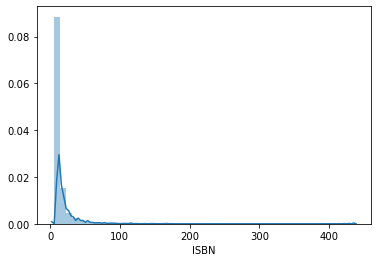

In [536]:
sns.distplot(rating_counts)

In [537]:
# n = 10000
# top_n = ratings.ISBN.value_counts().index[:n]

# most_rated = ratings[ratings.ISBN.isin(top_n)]
# most_rated.head()

In [538]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134299 entries, 0 to 134298
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userID      134299 non-null  int64 
 1   ISBN        134299 non-null  object
 2   bookRating  134299 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ MB


In [539]:
item_user_mat = pd.pivot_table(ratings, values=["bookRating"],
        index=["ISBN", "userID"],
        aggfunc=np.mean).unstack()

item_user_mat.shape

(10592, 12963)

In [540]:
item_user_mat.iloc[0:5, 0:5]

bookRating                
userID            8   99  114 232 242
ISBN                                 
0002005018        5.0 NaN NaN NaN NaN
0002251760        NaN NaN NaN NaN NaN
0002259001        NaN NaN NaN NaN NaN
0003300277        NaN NaN NaN NaN NaN
0006374921        NaN NaN NaN NaN NaN

In [541]:
# changing NaNs to 0s

item_user_mat.fillna(0, inplace=True)

In [542]:
# taking a look at most_rated_wide index
pd.Series(item_user_mat.index[:10])

0    0002005018
1    0002251760
2    0002259001
3    0003300277
4    0006374921
5    0006480764
6    000648302X
7    0006485014
8    0006485200
9    0006493580
Name: ISBN, dtype: object

## Method 1: Using cosine distance

First I will build a simple recommender based on cosine similarity  between books. To do that, first I will generate a user-book rating matrix frmo which I will perform collaborative filtering and recommend books based on user preferences. 

In [68]:
dists = cosine_similarity(item_user_mat)
dists

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [69]:
# transforming into a df and naming cols/rows

dists = pd.DataFrame(dists, columns=item_user_mat.index)

dists.index = dists.columns
dists.iloc[0:10, 0:10]

ISBN,0002005018,0002251760,0002259001,0003300277,0006374921,0006480764,000648302X,0006485014,0006485200,0006493580
ISBN,,,,,,,,,,
0002005018,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
0002251760,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
0002259001,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
0003300277,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0
0006374921,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0
0006480764,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.177856,0.0,0.0
000648302X,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0
0006485014,0.0,0.0,0.0,0.0,0.0,0.177856,0.0,1.000000,0.0,0.0
0006485200,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0


In [70]:
ISBNs_i_like = ['002542730X', '006019491X', '0060199652']
dists[ISBNs_i_like].head()

ISBN,002542730X,006019491X,0060199652
ISBN,,,
0002005018,0.0,0.000000,0.0
0002251760,0.0,0.098171,0.0
0002259001,0.0,0.000000,0.0
0003300277,0.0,0.000000,0.0
0006374921,0.0,0.000000,0.0


In [71]:
# sums cosine similarity 
ISBNs_summed = np.sum(dists[ISBNs_i_like], axis=1)
ISBNs_summed.sort_values(ascending=False, inplace=True)
ISBNs_summed

ISBN
0060199652    1.034455
006019491X    1.034455
002542730X    1.000000
0679732187    0.288229
0028604199    0.261533
                ...   
0553560735    0.000000
0553560727    0.000000
0553560719    0.000000
0553560441    0.000000
0002005018    0.000000
Length: 10592, dtype: float64

In [72]:
ranked_ISBNs = ISBNs_summed.index[ISBNs_summed.index.isin(ISBNs_i_like)==False]
ranked_ISBNs = ranked_ISBNs.tolist()
ranked_ISBNs[:5]

['0679732187', '0028604199', '0375406530', '0399146431', '0060275103']

In [73]:
def get_similar(books_list, n=1):
    """
    calculates which books are most similar to the inputs. Must not return
    the books that were inputted.
    
    Parameters
    ----------
    books: list
        ISBNs of books that have been detected from photos earlier
    
    Returns
    -------
    ranked_books: list
        rank ordered list of book ISBNs
    """
    ISBNs_summed = np.sum(dists[ISBNs_i_like], axis=1)

    books_list = [book for book in books_list if book in dists.columns]
    books_summed = np.sum(dists[books_list], axis=1)   # faster than apply/lambda
    #books_summed = dists[books_list].apply(lambda row: np.sum(row), axis=1)  # slower way to do it
    books_summed = books_summed.sort_values(ascending=False)
    ranked_books = books_summed.index[books_summed.index.isin(books_list)==False]
    ranked_books = ranked_books.tolist()
    
    if n is None:
        return ranked_books
    else:
        return ranked_books[:n]

In [74]:
get_similar('0671534734', 5)

['9871138148', '0393313964', '0393312801', '0393311147', '0393310396']

In [75]:
ISBN_to_title('9895550138')

ISBN not found.


In [76]:
books_rated[books_rated.ISBN=='0671534734']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,title_author
3806,0671534734,Unfinished Symphony (Logan),V.C. Andrews,1997,Pocket,http://images.amazon.com/images/P/0671534734.0...,http://images.amazon.com/images/P/0671534734.0...,http://images.amazon.com/images/P/0671534734.0...,unfinished symphony logan vc andrews


In [77]:
test_ISBN = "0671534734"
print(ISBN_to_title(test_ISBN), '\n')

[ISBN_to_title(rec) for rec in get_similar(test_ISBN, 5)]


unfinished symphony logan vc andrews 



['cien anos de soledad  one hundred years of solitude gabriel garcia marquez',
 'girl with curious hair norton paperback fiction david foster wallace',
 'the acid house irvine welsh',
 'sacred hunger norton paperback fiction barry unsworth',
 'letters to a young poet rainer maria rilke']

In [78]:
sample_isbns

['0316292168', '0465006965', '0670839531', '0812552849', '0517052687']

In [79]:
[ISBN_to_title(i) for i in sample_isbns]

['pandora a novel sylvia fraser',
 'religion explained the evolutionary origins of religious thought pascal boyer',
 'needful things the last castle rock story stephen king',
 'the fourth book of lost swords farslayers story farslayers story fred saberhagen',
 'yellow brick road wonderful wizard of oz popups series l frank baum']

In [80]:
print('TARGET BOOKS')

for val in sample_isbns:
    print(ISBN_to_title(val))
print('\n')
    
print('RECOMMENDATIONS')

[ISBN_to_title(rec) for rec in get_similar(sample_isbns, 15)]


TARGET BOOKS
pandora a novel sylvia fraser
religion explained the evolutionary origins of religious thought pascal boyer
needful things the last castle rock story stephen king
the fourth book of lost swords farslayers story farslayers story fred saberhagen
yellow brick road wonderful wizard of oz popups series l frank baum


RECOMMENDATIONS


['the dark half stephen king',
 'four past midnight stephen king',
 'rose madder stephen king',
 'insomnia stephen king',
 'the stand the complete and uncut edition stephen king',
 'nightmares amp dreamscapes stephen king',
 'dolores claiborne stephen king',
 'desperation stephen king',
 'the regulators richard bachman',
 'wizard and glass the dark tower book  stephen king',
 'the drawing of the three the dark tower book  stephen king',
 'waste lands tower  the dark tower iii stephen king',
 'it stephen king',
 'the tommyknockers stephen king',
 'the green mile the complete serial novel stephen king']

Since Stephen King is such a popular and culty novelist, his other works dominate the cosine similarity, which demonstrates how readers of Stephen King's works are much mroe likely to read other titles by him compared to the other books in this list. 

## Method 2: Single Variable Decomposition

In [543]:
!ls data

BX-CSV-Dump           rated_books_clean     user_item_mat.csv
BX-SQL-Dump           rated_books_clean.csv users_clean.csv
BX-SQL-Dump.zip       ratings_clean.csv     vt.csv
ISBNs.csv             sigma.csv             vt_10.csv
all_books_clean.csv   u.csv                 vt_100.csv


In [611]:
user_item_mat = item_user_mat.T

In [545]:
user_item_mat.to_csv('data/user_item_mat.csv', index=False)

In [612]:
# regular SVD

U, Sigma, VT = svd(user_item_mat)

In [83]:
# Truncated SVD

# svd = TruncatedSVD(n_components=2000)
# svd.fit(user_item_mat)

**U**:  
    cols = new dimensions  
    rows = users  
    
**VT**:  
    cols = items  
    rows = new dimensions    

**Sigma**: 
    singular values of decomposition
   

In [85]:
VT.shape

(10592, 10592)

In [86]:
U.shape

(12963, 12963)

In [87]:
Sigma.shape

(10592,)

### Saving to CSVs

In [ ]:
pd.Series(Sigma).head(800)

Text(0, 0.5, 'Sigma Value')

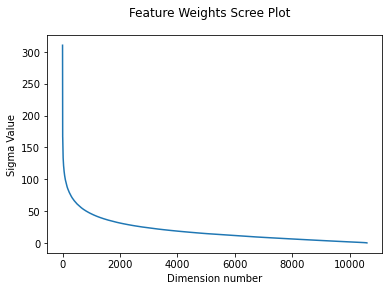

In [94]:
sns.lineplot(np.arange(len(Sigma)), Sigma)
plt.suptitle('Feature Weights Scree Plot')
plt.xlabel('Dimension number')
plt.ylabel('Sigma Value')

From this scree plot of Sigma values, we can see that although there is no clearly defined elbow, I determined that 800 would be a good cutoff for the number of features given that that is where the line begins to flatten the most. 

In [488]:
pd.Series(Sigma).head(20)

0     310.563391
1     200.273229
2     193.791116
3     178.940918
4     170.890937
5     166.643104
6     166.222528
7     163.362657
8     157.181485
9     155.293119
10    153.698197
11    148.217726
12    146.410817
13    145.031039
14    142.619638
15    140.707730
16    138.307097
17    137.376599
18    135.537244
19    134.621075
dtype: float64

In [558]:
test_array = np.array(['a', 'b', 'c'])

with open("save.p", "wb") as f:
    pickle.dump(test_array, f)

In [559]:
with open('save.p', 'rb') as f:
    data = pickle.load(f)

array(['a', 'b', 'c'], dtype='<U1')

In [595]:
#pd.DataFrame(np.diag(Sigma)).to_csv('data/sigma.csv', index=False)

with open("data/sigma.pkl", "wb") as f:
    pickle.dump(Sigma, open("data/sigma.pkl", "wb"))

In [613]:

VT_800 = VT[:800,:]       
U_800 = U[:,:800]

with open("data/vt_800.pkl", "wb") as f:
    pickle.dump(VT_800, f)
    
with open("data/u_800.pkl", "wb") as f:
    pickle.dump(U_800, f)

In [614]:
VT_650 = VT[:650,:]

with open("data/vt_650.pkl", "wb") as f:
    pickle.dump(VT_650, f)

In [615]:
VT_500 = VT[:500,:]

with open("data/vt_500.pkl", "wb") as f:
    pickle.dump(VT_500, f)

In [616]:
VT_250 = VT[:250,:]

with open("data/vt_250.pkl", "wb") as f:
    pickle.dump(VT_250, f)

In [617]:
VT_100 = VT[:100,:]

with open("data/vt_100.pkl", "wb") as f:
    pickle.dump(VT_100, f)

In [621]:
VT_100.shape

(100, 10592)

In [622]:
VT_50 = VT[:50,:]

with open("data/vt_50.pkl", "wb") as f:
    pickle.dump(VT_50, f)

In [623]:
VT_50.shape

(50, 10592)

In [619]:
VT_10 = VT[:10,:]

with open("data/vt_10.pkl", "wb") as f:
    pickle.dump(VT_10, f)

In [ ]:
dimension_names = ['dim' + str(i) for i in range(len(VT))]

ISBNs = user_item_mat.columns

user_ids = [x[1] for x in user_item_mat.index]

In [603]:
ISBNs

,Unnamed: 0,ISBN
0,0,0002005018
1,1,0002251760
2,2,0002259001
3,3,0003300277
4,4,0006374921
...,...,...
10587,10587,9726101794
10588,10588,9726106141
10589,10589,9727722458
10590,10590,9770390107900


In [604]:
pd.Series(ISBNs).to_csv('data/ISBNs.csv')

pd.Series(ISBNs).to_pickle('data/ISBNs.pkl')


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [422]:
user_item_mat.columns

Index(['0002005018', '0002251760', '0002259001', '0003300277', '0006374921',
       '0006480764', '000648302X', '0006485014', '0006485200', '0006493580',
       ...
       '9129622425', '950491036X', '9580464162', '9722015184', '9722020609',
       '9726101794', '9726106141', '9727722458', '9770390107900',
       '9871138148'],
      dtype='object', name='ISBN', length=10592)

In [519]:
# U: USER-NEW DIMENSION MATRIX 

pd.DataFrame(U, columns=dimension_names, index=user_ids).head()

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim790,dim791,dim792,dim793,dim794,dim795,dim796,dim797,dim798,dim799
8,-0.000014,-0.000035,0.000002,-0.000007,0.000002,-0.000038,0.000005,-0.000049,0.000021,-0.000010,...,-0.000764,-0.000095,0.000479,-0.000095,-0.000064,-0.000185,0.000139,0.000219,-0.000186,-0.000886
99,-0.000792,-0.000452,0.000216,-0.000141,-0.000980,0.000293,-0.000075,-0.001249,0.000422,0.000443,...,-0.001087,0.007844,0.000159,-0.008210,-0.003103,0.006708,-0.003821,-0.003671,0.003759,-0.001976
114,-0.003450,-0.001374,0.000886,0.001986,-0.003636,-0.001457,-0.001260,-0.012827,-0.007661,0.003153,...,0.007833,0.004888,-0.000896,0.009279,-0.005292,0.000662,-0.015110,0.007437,-0.009711,-0.007336
232,-0.000120,-0.000051,-0.000092,0.000067,0.000114,-0.000109,0.000153,0.000028,0.000337,-0.000288,...,0.001815,-0.001885,-0.000608,0.000904,0.003023,-0.000767,0.002568,-0.004546,-0.000963,-0.001896
242,-0.000483,-0.000167,-0.000559,0.001553,-0.000649,0.000061,0.001277,0.000461,0.000865,-0.000963,...,-0.007810,-0.004822,-0.003763,-0.002497,0.000706,-0.001220,-0.000327,0.004795,-0.000170,-0.001722


In [520]:
# VT.T ITEM-NEW DIMENSION MATRIX 
# transpose to put items as rows

pd.DataFrame(VT.T, columns=dimension_names, index=ISBNs).head()

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim790,dim791,dim792,dim793,dim794,dim795,dim796,dim797,dim798,dim799
"(0, 0002005018)",-0.000840,-0.001390,0.000089,-0.000251,0.000085,-0.001256,0.000171,-0.001611,0.000668,-0.000323,...,-0.007790,-0.000964,0.004874,-0.000968,-0.000654,-0.001880,0.001414,0.002221,-0.001883,-0.008981
"(1, 0002251760)",-0.004253,0.000429,-0.003097,-0.004374,-0.002508,-0.005010,0.008250,-0.002108,-0.001782,-0.002623,...,0.011674,-0.016628,0.009088,0.005035,-0.005703,0.010148,-0.000265,0.009064,0.013356,-0.011004
"(2, 0002259001)",-0.001576,-0.001635,0.000212,0.000418,0.002296,-0.000260,0.001310,-0.001610,0.001257,0.000058,...,0.004324,-0.004541,0.000044,-0.006536,-0.000494,0.002241,0.004077,-0.009403,0.005990,-0.010427
"(3, 0003300277)",-0.001166,-0.000653,-0.000477,0.001356,-0.002641,-0.001863,-0.001398,-0.004358,-0.000559,-0.000583,...,-0.012720,-0.001532,0.001059,-0.015002,0.002171,0.010039,0.005386,0.006151,0.004466,0.001367
"(4, 0006374921)",-0.000173,-0.000100,-0.000029,-0.000123,-0.000088,-0.000138,0.000343,-0.000687,0.000024,-0.000127,...,-0.001512,-0.000940,0.001538,-0.000054,0.002744,0.003748,0.001008,0.001800,-0.000637,0.001425


In [521]:
ratings

,userID,ISBN,bookRating
0,276747,0060517794,9
1,276747,0671537458,9
2,276747,0679776818,8
3,276822,0060096195,10
4,276822,0375821813,9
...,...,...,...
134294,276688,0743202694,10
134295,276688,0836218655,10
134296,276688,0836236688,10
134297,276704,0345386108,6


In [435]:
ISBNs

Index(['0002005018', '0002251760', '0002259001', '0003300277', '0006374921',
       '0006480764', '000648302X', '0006485014', '0006485200', '0006493580',
       ...
       '9129622425', '950491036X', '9580464162', '9722015184', '9722020609',
       '9726101794', '9726106141', '9727722458', '9770390107900',
       '9871138148'],
      dtype='object', name='ISBN', length=10592)

In [427]:
def drop_none(list_):
    return [x for x in list_ if x]

In [436]:
ISBNs = pd.read_csv('data/ISBNs.csv')
ISBNs

,Unnamed: 0,ISBN
0,0,0002005018
1,1,0002251760
2,2,0002259001
3,3,0003300277
4,4,0006374921
...,...,...
10587,10587,9726101794
10588,10588,9726106141
10589,10589,9727722458
10590,10590,9770390107900


In [478]:
def get_recommends(ISBN_val, VT=VT, num_recom=1, ISBNs=ISBNs):
    '''
    Takes book ISBN value and returns n recommended book ISBNs
    
    ISBN_val:
        str, ISBN numbers of books to base recommendations off of
    
    VT:
        matrix, product-feature matrix generated from SVD
    
    num_recom:
        int, number or recs to return
    
    ISBNs:
        object, list of columns from user-item matrix 
        aka user_item_mat.columns
    '''
    recs = []

    if ISBN_val is None:
        pass

    elif ISBN_val in ISBNs.ISBN.to_list():
        # converts ISBN to index
        itemID = ISBNs[ISBNs.ISBN.isin([ISBN_val])].index[0] # converts ISBN to index
        print(itemID)
        for item in range(VT.T.shape[0]):
            if item != itemID:
                recs.append([item, np.dot(VT.T[itemID], VT.T[item])])

        final_rec_index = [i[0] for i in sorted(recs, key=lambda x: x[1], reverse=True)]
        final_rec_isbn = [ISBNs.ISBN.iloc[i] for i in final_rec_index] # takes index and returns ISBN of book
        final = drop_none(final_rec_isbn[:num_recom])

        return final

    else:
        print('{} not in recommendation matrix'.format(ISBN_val))

get_recommends('0553275860', num_recom=2)

6488


['0553377884', '0679785892']

In [466]:
ISBNs.iloc[6630]

Unnamed: 0          6630
ISBN          0553377884
Name: 6630, dtype: object

In [463]:
ISBNs[ISBNs.ISBN.isin(['1573220876'])].index[0]


10033

In [397]:
VT.T.shape[0]

10592

In [589]:
def get_recommends_list(ISBN_list, VT=VT, n=1, ISBNs=ISBNs):
    '''
    takes list of ISBNs and returns recommendations and ISBNs of books used as basis for those recs
    ------------------------------------------------
    ISBN_list:
        list, ISBN numbers of books to base recommendations off of
    
    VT:
        matrix, product-feature matrix generated from SVD
    
    n:
        int, number or recs to return for each ISBN
    
    ISBNs:
        object, list of columns from user-item matrix 
        aka user_item_mat.columns
    '''
    
    recs = []
    basis = []
    
    for ISBN_val in ISBN_list:
        
        rec = get_recommends(ISBN_val, VT, num_recom=n, ISBNs=ISBNs)
        if rec:
            recs.append(rec)
            basis.append(ISBN_val)
    flat_recs = [i for sub in recs for i in sub]
    
    return flat_recs, basis

get_recommends_list([None, '1573220418', None, '0060974486', None, '0553275860', '0394702239'], n=2)

1573220418 not in recommendation matrix
389
6488
0394702239 not in recommendation matrix


(['0671787551', '1400077354', '0749316780', '0394178009'],
 ['0060974486', '0553275860'])

In [592]:
ISBN_to_title('0553275860')

2583


'narcissus and goldmund hermann hesse'

In [356]:
sample_isbns

['0061062332', '0373821697', '0679435050', '0385411596', '0375509194']

In [459]:
books_all[books_all.ISBN=='0679435050']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,title_author
142278,0679435050,Cleopatra's Nose: Essays on the Unexpected,Daniel J. Boorstin,1994,Random House,http://images.amazon.com/images/P/0679435050.0...,http://images.amazon.com/images/P/0679435050.0...,http://images.amazon.com/images/P/0679435050.0...,cleopatras nose essays on the unexpected danie...


In [358]:
print([ISBN_to_title(x) for x in sample_isbns])

[get_recommends(x, VT) for x in sample_isbns]

['ocean city reunion ocean city no  katherine applegate', 'in from the rain gina wilkins', 'cleopatras nose essays on the unexpected daniel j boorstin', 'mother earth father sky sue harrison', 'shedding years  growing older feeling younger phyllis greene']
0061062332 not in recommendation matrix
0373821697 not in recommendation matrix
0679435050 not in recommendation matrix
0385411596 not in recommendation matrix
0375509194 not in recommendation matrix


[None, None, None, None, None]

In [359]:
ISBN_to_title('0316292168')

'pandora a novel sylvia fraser'

In [360]:
books_all[books_all.ISBN=='0517052687']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,title_author
150316,0517052687,Yellow Brick Road (Wonderful Wizard of Oz Pop-...,L. Frank Baum,1991,Random House Value Publishing,http://images.amazon.com/images/P/0517052687.0...,http://images.amazon.com/images/P/0517052687.0...,http://images.amazon.com/images/P/0517052687.0...,yellow brick road wonderful wizard of oz popup...


## Testing SVD recommender on my books gathered using OCR

In [371]:
# setting variable for books scraped using OCR in earlier notebooks

test_books = [None, '1573220418', None, '0060974486', None, '0553275860', '0394702239']

In [372]:
# showing what titles we are starting with 

[ISBN_to_title(book) for book in test_books] 

[None,
 'drown junot diaz',
 None,
 'immortality milan kundera',
 None,
 'narcissus and goldmund hermann hesse',
 'the fall  albert camus']

In [390]:
# getting recommendations and basis for those recs

test_recs, test_basis = get_recommends_list(test_books, n=4) 

1573220418 not in recommendation matrix
0394702239 not in recommendation matrix


In [391]:
# recommendations 

[ISBN_to_title(x) for x in test_recs]

['a year in provence peter mayle',
 'about a boy nick hornby',
 'atlas shrugged ayn rand',
 'white teeth a novel zadie smith',
 'skinny legs and all tom robbins',
 'fear and loathing in las vegas  a savage journey to the heart of the american dream hunter s thompson',
 'siddhartha hermann hesse',
 'letters from the earth mark twain']

In [392]:
# books used to generate recommendations 

[ISBN_to_title(x) for x in test_basis]

['immortality milan kundera', 'narcissus and goldmund hermann hesse']

In [504]:
for i in books_all[books_all.ISBN=='0002005018'].imageUrlL:
    print(i)

http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg


In [497]:
books_all[books_all.ISBN=='0517052687'].imageUrlS

150316    http://images.amazon.com/images/P/0517052687.0...
Name: imageUrlS, dtype: object

In [507]:
books_all.head()


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,title_author
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,classical mythology mark p o morford
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,clara callan richard bruce wright
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,decision in normandy carlo deste
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,flu the story of the great influenza pandemic ...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,the mummies of urumchi e j w barber


In [ ]:
['0195153448', '0060973129', '0393045218']

In [512]:
from PIL import Image
import urllib.request, io


url = 'http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg'


with urllib.request.urlopen(url) as url:
    with open('temp.jpg', 'wb') as f:
        f.write(url.read())

img = Image.open('temp.jpg')

img.show()

In [513]:
ratings.shape

(134299, 3)

In [515]:
books_rated.shape

(10077, 9)

In [516]:
users.shape

(12854, 3)

In [517]:
ratings

,userID,ISBN,bookRating
0,276747,0060517794,9
1,276747,0671537458,9
2,276747,0679776818,8
3,276822,0060096195,10
4,276822,0375821813,9
...,...,...,...
134294,276688,0743202694,10
134295,276688,0836218655,10
134296,276688,0836236688,10
134297,276704,0345386108,6


In [518]:
VT

array([[-8.39758253e-04, -4.25263826e-03, -1.57629989e-03, ...,
        -1.38357592e-03, -7.02202708e-05, -1.60068806e-03],
       [-1.38960032e-03,  4.28775316e-04, -1.63502068e-03, ...,
        -1.26933300e-03, -4.96996561e-05, -9.52014647e-04],
       [ 8.91176408e-05, -3.09715926e-03,  2.12155188e-04, ...,
        -2.18966588e-03,  4.13468886e-05, -2.84388787e-03],
       ...,
       [ 2.22074872e-03,  9.06354994e-03, -9.40267512e-03, ...,
        -6.02976887e-03, -1.71402746e-03,  2.81756488e-03],
       [-1.88295588e-03,  1.33561639e-02,  5.99028452e-03, ...,
        -4.64932536e-03, -3.32205355e-03, -1.55999358e-03],
       [-8.98074636e-03, -1.10044528e-02, -1.04266977e-02, ...,
        -1.86508347e-03, -6.44493397e-04,  2.47770658e-03]])

In [610]:
books_all.iloc['0679781587']

TypeError: Cannot index by location index with a non-integer key

In [607]:
books_all.columns

Index(['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher',
       'imageUrlS', 'imageUrlM', 'imageUrlL', 'title_author'],
      dtype='object')